In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.policy import AdaGreedPolicy, EpsGreedPolicy
from src.provider import BatchProvider,SampleProvider
from src.oracle import NeuralOracle, OnRegOracle, RegTreeOracle
from src.domain import Agent, ChurnEnvironment, learn

In [ ]:
data = pd.read_csv("data/cleaned.csv")
data = data.assign(action = np.where(data.churn == "No", 0, 1))
data = data.drop(["customerid", "churn"], axis = 1)
data = pd.get_dummies(data, drop_first = True)

rewards = pd.DataFrame({
    "act":  [0,    0,    1,    1],
    "pred": [0,    1,    0,    1],
    #"val":  [1,   -1,   -2,    0]
    "val": [1, -1.5,   -2,  0.5]
})

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(20, activation = 'relu', input_shape=(30,)))
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1))

In [ ]:
ITER = 8000
agent = Agent(BatchProvider(100), OnRegOracle([0,1], -2), AdaGreedPolicy(thresh = 0.9, decay = 0.999))
# agent = Agent(BatchProvider(200), NeuralOracle([0,1], -2, model, 50, 20, 0), AdaGreedPolicy(thresh = 0.9, decay = 0.999, soft = True))
env = ChurnEnvironment(data, rewards)

In [ ]:
a = learn(agent, env, iters = ITER, update_freq = 100)

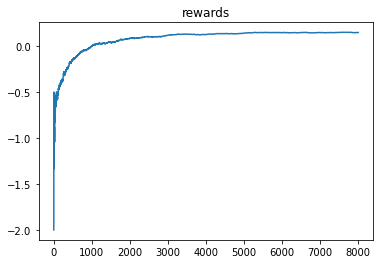

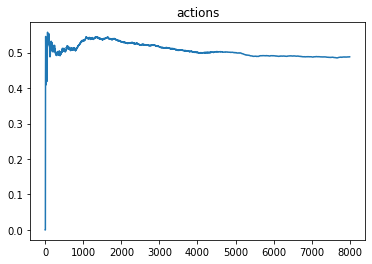

{'reward': 0.148375, 'action': 0.488}

In [ ]:
rew = pd.Series(a.provider.rewards)
act = pd.Series(a.provider.actions)

plt.plot(range(ITER), rew.cumsum() / range(1,ITER+1))
plt.title("rewards")
plt.show()

plt.plot(range(ITER), act.cumsum() / range(1,ITER+1))
plt.title("actions")
plt.show()

{"reward": rew.mean(), "action": act.mean()}

## Manual predictions

In [ ]:
b = a.provider.provide(1000)

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

ACTION = 0

c = b.query('action==@ACTION')
scaled = a.oracle.scalers[ACTION].transform(c.drop(['action','reward'], axis = 1))
pred = a.oracle.oracles[ACTION].predict(scaled)
c = c.assign(pred = pred)

MSE(pred, c.reward, squared=False)

1.1175961112270008

In [ ]:
cols = ['reward','pred', 'action']
cols.extend(c.columns[:-2].to_list())
c[cols]

,reward,pred,action,tenure,monthlycharges,totalcharges,gender_Male,seniorcitizen_yes,partner_Yes,dependents_Yes,...,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,action
6101,1.0,0.109657,0,69,110.25,7467.55,0,1,0,0,...,1,0,1,0,1,0,1,0,0,0
4984,1.0,0.504866,0,42,59.65,2536.55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3870,1.0,-0.190487,0,68,54.40,3723.65,0,0,1,0,...,1,0,1,1,0,1,0,1,0,0
2792,1.0,-1.117521,0,15,48.85,736.80,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1335,-2.0,-1.220804,0,2,45.00,96.45,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241,-2.0,-0.580798,0,1,20.10,20.10,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4325,1.0,-0.250866,0,1,20.75,20.75,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3875,-2.0,-0.628701,0,41,111.95,4534.90,1,1,1,1,...,1,0,1,1,0,1,0,1,0,0
1961,1.0,0.684005,0,42,60.15,2421.60,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
